In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import Counter

# 从SNLI目录加载parquet数据
def load_snli_from_local(data_dir="SNLI"):
    """
    从本地SNLI目录加载Parquet格式的数据集
    """
    def read_parquet(filepath):
        """读取Parquet格式文件"""
        try:
            df = pd.read_parquet(filepath)
            print(f"成功读取 {filepath}, 形状: {df.shape}")
            print(f"列名: {list(df.columns)}")
            
            # 打印前几行看看数据格式
            print("数据样例:")
            print(df.head(2))
            
            # 根据实际列名调整
            premise_col = None
            hypothesis_col = None
            label_col = None
            
            # 自动检测列名
            for col in df.columns:
                col_lower = col.lower()
                if 'sentence1' in col_lower or 'premise' in col_lower:
                    premise_col = col
                elif 'sentence2' in col_lower or 'hypothesis' in col_lower:
                    hypothesis_col = col
                elif 'gold_label' in col_lower or 'label' in col_lower:
                    label_col = col
            
            if not all([premise_col, hypothesis_col, label_col]):
                print(f"无法自动识别列名，请检查数据格式")
                print(f"可用列: {list(df.columns)}")
                return [], [], []
            
            print(f"使用列映射: premise={premise_col}, hypothesis={hypothesis_col}, label={label_col}")
            
            # 标签映射
            label_map = {
                'entailment': 0, 
                'neutral': 1, 
                'contradiction': 2,
                0: 0, 1: 1, 2: 2
            }
            
            premises = []
            hypotheses = []
            labels = []
            
            for idx, row in df.iterrows():
                premise = str(row[premise_col]).strip()
                hypothesis = str(row[hypothesis_col]).strip()
                label_val = row[label_col]
                
                # 跳过无效数据
                if pd.isna(premise) or pd.isna(hypothesis) or pd.isna(label_val):
                    continue
                if premise == '' or hypothesis == '' or premise == 'nan' or hypothesis == 'nan':
                    continue
                
                # 处理标签
                if label_val in label_map:
                    premises.append(premise)
                    hypotheses.append(hypothesis)
                    labels.append(label_map[label_val])
            
            print(f"有效数据条数: {len(labels)}")
            return premises, hypotheses, labels
            
        except Exception as e:
            print(f"读取文件出错 {filepath}: {e}")
            return [], [], []
    
    # 检查SNLI目录是否存在
    if not os.path.exists(data_dir):
        print(f"SNLI目录不存在: {data_dir}")
        return None
    
    # 列出SNLI目录中的所有文件
    files = os.listdir(data_dir)
    parquet_files = [f for f in files if f.endswith('.parquet')]
    
    print(f"在SNLI目录中找到以下文件:")
    for f in files:
        print(f"  {f}")
    
    if not parquet_files:
        print("未找到parquet文件")
        return None
    
    print(f"Parquet文件: {parquet_files}")
    
    # 根据文件名分配train/dev/test
    train_file = None
    dev_file = None
    test_file = None
    
    for f in parquet_files:
        f_lower = f.lower()
        if 'train' in f_lower:
            train_file = f
        elif 'dev' in f_lower or 'validation' in f_lower:
            dev_file = f
        elif 'test' in f_lower:
            test_file = f
    
    # 如果只有一个文件，假设是训练集
    if len(parquet_files) == 1:
        train_file = parquet_files[0]
        print(f"只找到一个文件，将作为训练集使用: {train_file}")
    
    # 读取数据
    train_premises, train_hypotheses, train_labels = [], [], []
    val_premises, val_hypotheses, val_labels = [], [], []
    test_premises, test_hypotheses, test_labels = [], [], []
    
    if train_file:
        train_path = os.path.join(data_dir, train_file)
        train_premises, train_hypotheses, train_labels = read_parquet(train_path)
    
    if dev_file:
        dev_path = os.path.join(data_dir, dev_file)
        val_premises, val_hypotheses, val_labels = read_parquet(dev_path)
    
    if test_file:
        test_path = os.path.join(data_dir, test_file)
        test_premises, test_hypotheses, test_labels = read_parquet(test_path)
    
    return {
        'train': {
            'premise': train_premises,
            'hypothesis': train_hypotheses,
            'label': train_labels
        },
        'validation': {
            'premise': val_premises,
            'hypothesis': val_hypotheses,
            'label': val_labels
        },
        'test': {
            'premise': test_premises,
            'hypothesis': test_hypotheses,
            'label': test_labels
        }
    }

# SNLI数据集类
class SNLIDataset(Dataset):
    def __init__(self, premises, hypotheses, labels, vocab=None, tokenizer=None, max_len=128, use_bert=False):
        self.premises = premises
        self.hypotheses = hypotheses
        self.labels = labels
        self.max_len = max_len
        self.use_bert = use_bert
        
        if use_bert:
            self.tokenizer = tokenizer
        else:
            self.vocab = vocab
            self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        premise = self.premises[idx]
        hypothesis = self.hypotheses[idx]
        label = self.labels[idx]
        
        if self.use_bert:
            # BERT tokenization
            encoding = self.tokenizer(
                premise,
                hypothesis,
                truncation=True,
                padding='max_length',
                max_length=self.max_len,
                return_tensors='pt'
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'token_type_ids': encoding['token_type_ids'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            # GloVe tokenization
            premise_tokens = premise.lower().split()
            hypothesis_tokens = hypothesis.lower().split()
            
            premise_ids = [self.word_to_idx.get(token, 1) for token in premise_tokens]
            hypothesis_ids = [self.word_to_idx.get(token, 1) for token in hypothesis_tokens]
            
            # 截断或填充
            if len(premise_ids) > self.max_len:
                premise_ids = premise_ids[:self.max_len]
            else:
                premise_ids += [0] * (self.max_len - len(premise_ids))
            
            if len(hypothesis_ids) > self.max_len:
                hypothesis_ids = hypothesis_ids[:self.max_len]
            else:
                hypothesis_ids += [0] * (self.max_len - len(hypothesis_ids))
            
            return {
                'premise_ids': torch.tensor(premise_ids, dtype=torch.long),
                'hypothesis_ids': torch.tensor(hypothesis_ids, dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)
            }

# 构建SNLI词汇表
def build_snli_vocab(premises, hypotheses, min_freq=2):
    counter = Counter()
    
    for premise in premises:
        tokens = premise.lower().split()
        counter.update(tokens)
    
    for hypothesis in hypotheses:
        tokens = hypothesis.lower().split()
        counter.update(tokens)
    
    vocab = ['<pad>', '<unk>'] + [word for word, freq in counter.items() if freq >= min_freq]
    return vocab

# Model 1: GloVe + BiLSTM for SNLI
class GloVeBiLSTMSNLI(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(GloVeBiLSTMSNLI, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        
        # 特征组合: premise + hypothesis + interaction
        self.fc = nn.Linear(hidden_dim * 4 * 2, num_classes)
    
    def forward(self, x):
        premise_ids = x['premise_ids']
        hypothesis_ids = x['hypothesis_ids']
        
        # 编码premise
        premise_emb = self.embedding(premise_ids)
        premise_lstm, _ = self.lstm(premise_emb)
        premise_repr = premise_lstm[:, -1, :]
        
        # 编码hypothesis
        hypothesis_emb = self.embedding(hypothesis_ids)
        hypothesis_lstm, _ = self.lstm(hypothesis_emb)
        hypothesis_repr = hypothesis_lstm[:, -1, :]
        
        # 特征组合
        combined = torch.cat([
            premise_repr,
            hypothesis_repr,
            premise_repr * hypothesis_repr,
            torch.abs(premise_repr - hypothesis_repr)
        ], dim=1)
        
        output = self.dropout(combined)
        output = self.fc(output)
        
        return output

# Model 2: BERT嵌入 + BiLSTM for SNLI
class BertBiLSTMSNLI(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_classes, freeze_bert=True):
        super(BertBiLSTMSNLI, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.lstm = nn.LSTM(768, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        bert_output = self.bert(
            input_ids=x['input_ids'],
            attention_mask=x['attention_mask'],
            token_type_ids=x['token_type_ids']
        )
        
        lstm_out, _ = self.lstm(bert_output.last_hidden_state)
        cls_output = lstm_out[:, 0, :]  # 使用[CLS] token
        
        output = self.dropout(cls_output)
        output = self.fc(output)
        
        return output

# Model 3: BERT微调 for SNLI
class BertFineTuneSNLI(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertFineTuneSNLI, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)
    
    def forward(self, x):
        bert_output = self.bert(
            input_ids=x['input_ids'],
            attention_mask=x['attention_mask'],
            token_type_ids=x['token_type_ids']
        )
        
        cls_output = bert_output.last_hidden_state[:, 0, :]  # [CLS] token
        output = self.dropout(cls_output)
        output = self.fc(output)
        
        return output

# 训练函数
def train_snli_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """训练SNLI模型"""
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        
        for batch in train_pbar:
            # 将数据移到设备上
            for key in batch:
                batch[key] = batch[key].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(batch)
            loss = criterion(outputs, batch['label'])
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 验证阶段
        if val_loader:
            val_accuracy = evaluate_snli_model(model, val_loader, device)
            val_accuracies.append(val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}')
    
    return train_losses, val_accuracies

def evaluate_snli_model(model, data_loader, device):
    """评估SNLI模型"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            # 将数据移到设备上
            for key in batch:
                batch[key] = batch[key].to(device)
            
            outputs = model(batch)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# 过滤数据函数
def filter_data(split_data):
    """过滤有效数据"""
    premises = split_data['premise']
    hypotheses = split_data['hypothesis']
    labels = split_data['label']
    
    # 如果数据已经是过滤后的，直接返回
    return premises, hypotheses, labels

c:\Users\HP\.conda\envs\torch_2.1.1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 数据加载与预处理 ---
print("Loading SNLI dataset from local directory...")
dataset = load_snli_from_local("2 SNLI")

if dataset is None:
    print("数据集加载失败")
    # 根据上下文，这里可能是 return 或 exit()
    exit()

train_premises = dataset['train']['premise']
train_hypotheses = dataset['train']['hypothesis']
train_labels = dataset['train']['label']

val_premises = dataset['validation']['premise']
val_hypotheses = dataset['validation']['hypothesis']
val_labels = dataset['validation']['label']

# 为了快速实验，限制数据量
train_size = min(10000, len(train_labels))
val_size = min(2000, len(val_labels))

train_premises = train_premises[:train_size]
train_hypotheses = train_hypotheses[:train_size]
train_labels = train_labels[:train_size]

val_premises = val_premises[:val_size]
val_hypotheses = val_hypotheses[:val_size]
val_labels = val_labels[:val_size]

print(f"Train size: {len(train_labels)}")
print(f"Val size: {len(val_labels)}")


Using device: cuda
Loading SNLI dataset from local directory...
在SNLI目录中找到以下文件:
  test-00000-of-00001.parquet
  train-00000-of-00001.parquet
  validation-00000-of-00001.parquet
Parquet文件: ['test-00000-of-00001.parquet', 'train-00000-of-00001.parquet', 'validation-00000-of-00001.parquet']
成功读取 2 SNLI\train-00000-of-00001.parquet, 形状: (550152, 3)
列名: ['premise', 'hypothesis', 'label']
数据样例:
                                             premise  \
0  A person on a horse jumps over a broken down a...   
1  A person on a horse jumps over a broken down a...   

                                          hypothesis  label  
0  A person is training his horse for a competition.      1  
1      A person is at a diner, ordering an omelette.      2  
使用列映射: premise=premise, hypothesis=hypothesis, label=label
有效数据条数: 549367
成功读取 2 SNLI\validation-00000-of-00001.parquet, 形状: (10000, 3)
列名: ['premise', 'hypothesis', 'label']
数据样例:
                                             premise  \
0  Two women are

In [3]:
# ======================== Model 1: GloVe + BiLSTM ========================
print("\n=== Training Model 1: GloVe + BiLSTM (SNLI) ===")

# 构建词汇表
vocab = build_snli_vocab(train_premises + train_hypotheses, train_premises + train_hypotheses)
print(f"Vocabulary size: {len(vocab)}")

# 创建数据集
train_dataset_glove = SNLIDataset(
    train_premises, train_hypotheses, train_labels,
    vocab=vocab, max_len=64, use_bert=False
)
val_dataset_glove = SNLIDataset(
    val_premises, val_hypotheses, val_labels,
    vocab=vocab, max_len=64, use_bert=False
)

train_loader_glove = DataLoader(train_dataset_glove, batch_size=64, shuffle=True)
val_loader_glove = DataLoader(val_dataset_glove, batch_size=64)

# 创建模型
model1 = GloVeBiLSTMSNLI(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_dim=128,
    num_classes=3,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)

# 训练
train_losses1, val_accs1 = train_snli_model(
    model1, train_loader_glove, val_loader_glove,
    criterion, optimizer1, num_epochs=5, device=device
)

print(f"Model 1 (GloVe + BiLSTM) - Best Val Acc: {max(val_accs1):.4f}")


=== Training Model 1: GloVe + BiLSTM (SNLI) ===
Vocabulary size: 7903


Epoch 1/5, Loss: 1.0990, Val Acc: 0.3300


Epoch 2/5, Loss: 1.0991, Val Acc: 0.3315


Epoch 3/5, Loss: 1.0991, Val Acc: 0.3315


Epoch 4/5, Loss: 1.0990, Val Acc: 0.3315


Epoch 5/5, Loss: 1.0989, Val Acc: 0.3300
Model 1 (GloVe + BiLSTM) - Best Val Acc: 0.3315


In [4]:
# ======================== Model 2: BERT嵌入 + BiLSTM ========================
print("\n=== Training Model 2: BERT嵌入 + BiLSTM (SNLI) ===")

# 加载BERT tokenizer (使用本地模型)
bert_path = "./bert-base-uncased-local"
tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)

# 创建数据集
train_dataset_bert = SNLIDataset(
    train_premises, train_hypotheses, train_labels,
    tokenizer=tokenizer, max_len=128, use_bert=True
)
val_dataset_bert = SNLIDataset(
    val_premises, val_hypotheses, val_labels,
    tokenizer=tokenizer, max_len=128, use_bert=True
)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=32)

# 创建模型
model2 = BertBiLSTMSNLI(
    bert_model_name=bert_path,
    hidden_dim=128,
    num_classes=3,
    freeze_bert=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=2e-5)

# 训练
train_losses2, val_accs2 = train_snli_model(
    model2, train_loader_bert, val_loader_bert,
    criterion, optimizer2, num_epochs=3, device=device
)

print(f"Model 2 (BERT嵌入 + BiLSTM) - Best Val Acc: {max(val_accs2):.4f}")


=== Training Model 2: BERT嵌入 + BiLSTM (SNLI) ===


Epoch 1/3, Loss: 1.0830, Val Acc: 0.4680


Epoch 2/3, Loss: 1.0553, Val Acc: 0.4915


Epoch 3/3, Loss: 1.0363, Val Acc: 0.5030
Model 2 (BERT嵌入 + BiLSTM) - Best Val Acc: 0.5030


In [5]:
# ======================== Model 3: BERT微调 ========================
print("\n=== Training Model 3: BERT微调 (SNLI) ===")
# 加载BERT tokenizer (使用本地模型)
bert_path = "./bert-base-uncased-local"

tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)

# 创建数据集
train_dataset_bert = SNLIDataset(
    train_premises, train_hypotheses, train_labels,
    tokenizer=tokenizer, max_len=128, use_bert=True
)
val_dataset_bert = SNLIDataset(
    val_premises, val_hypotheses, val_labels,
    tokenizer=tokenizer, max_len=128, use_bert=True
)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=32)

# 创建模型
model3 = BertFineTuneSNLI(
    bert_model_name=bert_path,
    num_classes=3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=2e-5)

# 训练
train_losses3, val_accs3 = train_snli_model(
    model3, train_loader_bert, val_loader_bert,
    criterion, optimizer3, num_epochs=3, device=device
)

print(f"Model 3 (BERT微调) - Best Val Acc: {max(val_accs3):.4f}")

# ======================== 结果比较 ========================
print("\n=== 模型性能比较 ===")
print(f"Model 1 (GloVe + BiLSTM): {max(val_accs1):.4f}")
print(f"Model 2 (BERT嵌入 + BiLSTM): {max(val_accs2):.4f}")
print(f"Model 3 (BERT微调): {max(val_accs3):.4f}")



=== Training Model 3: BERT微调 (SNLI) ===


Epoch 1/3, Loss: 0.7382, Val Acc: 0.8030


Epoch 2/3, Loss: 0.4439, Val Acc: 0.8250


Epoch 3/3, Loss: 0.2919, Val Acc: 0.8180
Model 3 (BERT微调) - Best Val Acc: 0.8250

=== 模型性能比较 ===
Model 1 (GloVe + BiLSTM): 0.3315
Model 2 (BERT嵌入 + BiLSTM): 0.5030
Model 3 (BERT微调): 0.8250


C:\Users\HP\AppData\Local\Temp\ipykernel_43916\1385217329.py:22: UserWarning: Glyph 23884 (\N{CJK UNIFIED IDEOGRAPH-5D4C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_43916\1385217329.py:22: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_43916\1385217329.py:22: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_43916\1385217329.py:22: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\.conda\envs\torch_2.1.1\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23884 (\N{CJK UNIFIED IDEOGRAPH-5D4C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HP\.conda\envs\torch_2.1.1\lib\site-packages\IPython\core\p

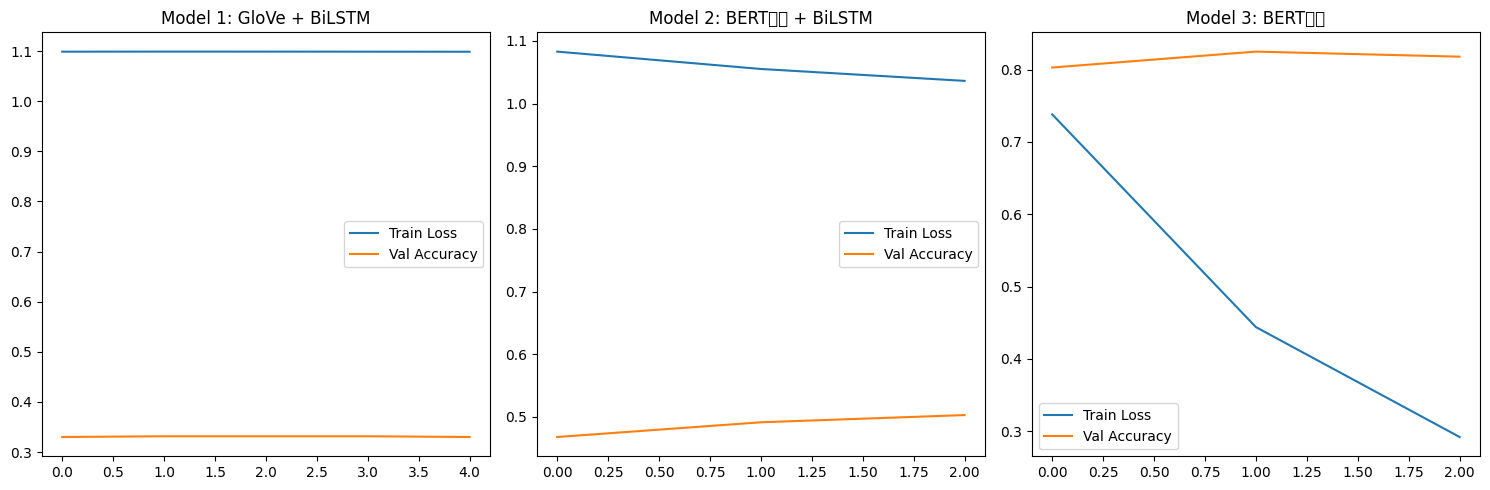

In [6]:
# ======================== 绘制训练曲线 ========================
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses1, label='Train Loss')
plt.plot(val_accs1, label='Val Accuracy')
plt.title('Model 1: GloVe + BiLSTM')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_accs2, label='Val Accuracy')
plt.title('Model 2: BERT嵌入 + BiLSTM')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses3, label='Train Loss')
plt.plot(val_accs3, label='Val Accuracy')
plt.title('Model 3: BERT微调')
plt.legend()

plt.tight_layout()
plt.show()